In [1]:
# pip install neuralforecast datasetsforecast

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.8/254.8 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 271.4/271.4 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 45.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 MB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.6/890.6 kB 60.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial.legendre import Legendre
from numpy.polynomial.chebyshev import Chebyshev
from scipy.interpolate import BSpline

def generate_legendre_basis(length, n_basis):
    """
    Generates Legendre polynomial basis functions.

    Parameters:
    - n_points (int): Number of data points.
    - n_functions (int): Number of basis functions to generate.

    Returns:
    - legendre_basis (ndarray): An array of Legendre basis functions.
    """
    x = np.linspace(-1, 1, length)  # Legendre polynomials are defined on [-1, 1]
    legendre_basis = np.zeros((length, n_basis))

    for i in range(n_basis):
        # Legendre polynomial of degree i
        P_i = Legendre.basis(i)
        legendre_basis[:, i] = P_i(x)

    return legendre_basis


def generate_polynomial_2_basis(length, n_basis):
    """
    Generates standard polynomial basis functions.

    Parameters:
    - n_points (int): Number of data points.
    - n_functions (int): Number of polynomial functions to generate.

    Returns:
    - poly_basis (ndarray): An array of polynomial basis functions.
    """
    x = np.linspace(-1, 1, length)
    poly_basis = np.zeros((length, n_basis))

    for i in range(n_basis):
        poly_basis[:, i] = x ** i

    return poly_basis

def generate_polynomial_basis(length, n_basis):
    """
    Generates standard polynomial basis functions.

    Parameters:
    - n_points (int): Number of data points.
    - n_functions (int): Number of polynomial functions to generate.

    Returns:
    - poly_basis (ndarray): An array of polynomial basis functions.
    """
    return np.concatenate([np.power(np.arange(length, dtype=float) / length, i)[None, :]
                                    for i in range(n_basis)]).T


def generate_changepoint_basis(length, n_basis):
    """
    Generates changepoint basis functions with automatically spaced changepoints.

    Parameters:
    - n_points (int): Number of data points.
    - n_functions (int): Number of changepoint functions to generate.

    Returns:
    - changepoint_basis (ndarray): An array of changepoint basis functions.
    """
    x = np.linspace(0, 1, length)
    changepoint_basis = np.zeros((length, n_basis))

    # Evenly space changepoint locations between 0 and 1
    changepoint_locations = np.linspace(0, 1, n_basis + 1)[1:]  # Avoid 0 to prevent all zeros

    for i, cp in enumerate(changepoint_locations):
        changepoint_basis[:, i] = np.maximum(0, x - cp)

    return changepoint_basis

def generate_piecewise_linear_basis(length, n_basis):
    """
    Generates piecewise linear basis functions (linear splines).

    Parameters:
    - n_points (int): Number of data points.
    - n_functions (int): Number of piecewise linear basis functions to generate.

    Returns:
    - pw_linear_basis (ndarray): An array of piecewise linear basis functions.
    """
    x = np.linspace(0, 1, length)
    knots = np.linspace(0, 1, n_basis+1)
    pw_linear_basis = np.zeros((length, n_basis))

    for i in range(1, n_basis):
        pw_linear_basis[:, i] = np.maximum(0, np.minimum((x - knots[i-1]) / (knots[i] - knots[i-1]), (knots[i+1] - x) / (knots[i+1] - knots[i])))

    return pw_linear_basis

def generate_spline_basis(length, n_basis):
    """
    Generates cubic spline basis functions.

    Parameters:
    - n_points (int): Number of data points.
    - n_functions (int): Number of basis functions.

    Returns:
    - spline_basis (ndarray): An array of cubic spline basis functions.
    """
    x = np.linspace(0, 1, length)
    knots = np.linspace(0, 1, n_basis - 2)  # Internal knots
    t = np.concatenate(([0, 0, 0], knots, [1, 1, 1]))  # Knot sequence for cubic splines
    degree = 3  # Cubic splines

    spline_basis = np.zeros((length, n_basis))
    for i in range(n_basis):
        coef = np.zeros(n_basis)
        coef[i] = 1  # Each basis function has one coefficient set to 1
        spline = BSpline(t, coef, degree)
        spline_basis[:, i] = spline(x)

    return spline_basis

def generate_chebyshev_basis(length, n_basis):
    """
    Generates Chebyshev polynomial basis functions.

    Parameters:
    - n_points (int): Number of data points.
    - n_functions (int): Number of Chebyshev polynomials to generate.

    Returns:
    - chebyshev_basis (ndarray): An array of Chebyshev polynomial basis functions.
    """
    x = np.linspace(-1, 1, length)
    chebyshev_basis = np.zeros((length, n_basis))

    for i in range(n_basis):
        T_i = Chebyshev.basis(i)
        chebyshev_basis[:, i] = T_i(x)

    return chebyshev_basis

def generate_piecewise_2_basis(length, n_basis):
    array_splits = np.array_split(np.zeros(length),n_basis+1)[:-1]
    initial_point = 0
    final_point = 0
    changepoints = np.zeros(shape=(length, n_basis))
    len_splits = 0
    for i in range(n_basis):
        len_splits += len(array_splits[i])
        moving_point = 1
        left_basis = np.linspace(initial_point,
                                  moving_point,
                                  len_splits)
        end_point = 0
        right_basis = np.linspace(moving_point,
                                  end_point,
                                  length - len_splits + 1)
        changepoints[:, i] = np.append(left_basis, right_basis[1:])
    # changepoints[:, i+1] = 1
    return changepoints

In [3]:
# -*- coding: utf-8 -*-
from typing import Tuple, Optional

import numpy as np
import torch
import torch.nn as nn

from neuralforecast.losses.pytorch import MAE
from neuralforecast.common._base_windows import BaseWindows

class IdentityBasis(nn.Module):
    def __init__(self, backcast_size: int, forecast_size: int,
                 out_features: int=1):
        super().__init__()
        self.out_features = out_features
        self.forecast_size = forecast_size
        self.backcast_size = backcast_size

    def forward(self, theta: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        backcast = theta[:, :self.backcast_size]
        forecast = theta[:, self.backcast_size:]
        forecast = forecast.reshape(len(forecast), -1, self.out_features)
        return backcast, forecast

def get_basis(length, n_basis, basis):
    basis_dict = {
        'legendre': generate_legendre_basis,
        'polynomial': generate_polynomial_basis,
        'polynomial_2': generate_polynomial_2_basis,
        'changepoint': generate_changepoint_basis,
        'piecewise_linear': generate_piecewise_linear_basis,
        'piecewise_linear_2': generate_piecewise_2_basis,
        'spline': generate_spline_basis,
        'chebyshev': generate_chebyshev_basis
    }
    return basis_dict[basis](length, n_basis+1)

class TrendBasis(nn.Module):
    def __init__(self, n_basis: int,
                 backcast_size: int,
                 forecast_size: int,
                 out_features: int=1,
                 basis='polynomial'):
        super().__init__()
        self.out_features = out_features
        # polynomial_size = degree_of_polynomial + 2
        self.backcast_basis = nn.Parameter(
            torch.tensor(get_basis(backcast_size, n_basis, basis).T, dtype=torch.float32), requires_grad=False)
        self.forecast_basis = nn.Parameter(
            torch.tensor(get_basis(forecast_size, n_basis, basis).T, dtype=torch.float32), requires_grad=False)

    def forward(self, theta: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        polynomial_size = self.forecast_basis.shape[0] # [polynomial_size, L+H]
        backcast_theta = theta[:, :polynomial_size]
        forecast_theta = theta[:, polynomial_size:]
        forecast_theta = forecast_theta.reshape(len(forecast_theta),polynomial_size,-1)
        backcast = torch.einsum('bp,pt->bt', backcast_theta, self.backcast_basis)
        forecast = torch.einsum('bpq,pt->btq', forecast_theta, self.forecast_basis)
        return backcast, forecast

class SeasonalityBasis(nn.Module):
    def __init__(self, harmonics: int,
                 backcast_size: int, forecast_size: int,
                 out_features: int=1):
        super().__init__()
        self.out_features = out_features
        frequency = np.append(np.zeros(1, dtype=float),
                                        np.arange(harmonics, harmonics / 2 * forecast_size,
                                                    dtype=float) / harmonics)[None, :]
        backcast_grid = -2 * np.pi * (
                np.arange(backcast_size, dtype=float)[:, None] / forecast_size) * frequency
        forecast_grid = 2 * np.pi * (
                np.arange(forecast_size, dtype=float)[:, None] / forecast_size) * frequency

        backcast_cos_template = torch.tensor(np.transpose(np.cos(backcast_grid)), dtype=torch.float32)
        backcast_sin_template = torch.tensor(np.transpose(np.sin(backcast_grid)), dtype=torch.float32)
        backcast_template = torch.cat([backcast_cos_template, backcast_sin_template], dim=0)

        forecast_cos_template = torch.tensor(np.transpose(np.cos(forecast_grid)), dtype=torch.float32)
        forecast_sin_template = torch.tensor(np.transpose(np.sin(forecast_grid)), dtype=torch.float32)
        forecast_template = torch.cat([forecast_cos_template, forecast_sin_template], dim=0)

        self.backcast_basis = nn.Parameter(backcast_template, requires_grad=False)
        self.forecast_basis = nn.Parameter(forecast_template, requires_grad=False)

    def forward(self, theta: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        harmonic_size = self.forecast_basis.shape[0] # [harmonic_size, L+H]
        backcast_theta = theta[:, :harmonic_size]
        forecast_theta = theta[:, harmonic_size:]
        forecast_theta = forecast_theta.reshape(len(forecast_theta),harmonic_size,-1)
        backcast = torch.einsum('bp,pt->bt', backcast_theta, self.backcast_basis)
        forecast = torch.einsum('bpq,pt->btq', forecast_theta, self.forecast_basis)
        return backcast, forecast



ACTIVATIONS = ['ReLU',
               'Softplus',
               'Tanh',
               'SELU',
               'LeakyReLU',
               'PReLU',
               'Sigmoid']

class NPBEATSBlock(nn.Module):
    """
    N-PBEATS block which takes a basis function as an argument.
    """
    def __init__(self,
                 input_size: int,
                 n_theta: int,
                 mlp_units: list,
                 basis: nn.Module,
                 dropout_prob: float,
                 activation: str):
        """
        """
        super().__init__()

        self.dropout_prob = dropout_prob

        assert activation in ACTIVATIONS, f'{activation} is not in {ACTIVATIONS}'
        activ = getattr(nn, activation)()

        hidden_layers = [nn.Linear(in_features=input_size,
                                   out_features=mlp_units[0][0])]
        for layer in mlp_units:
            hidden_layers.append(nn.Linear(in_features=layer[0],
                                           out_features=layer[1]))
            hidden_layers.append(activ)

            if self.dropout_prob>0:
                raise NotImplementedError('dropout')
                #hidden_layers.append(nn.Dropout(p=self.dropout_prob))

        output_layer = [nn.Linear(in_features=mlp_units[-1][1], out_features=n_theta)]
        layers = hidden_layers + output_layer
        self.layers = nn.Sequential(*layers)
        self.basis = basis

    def forward(self, insample_y: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        # Compute local projection weights and projection
        theta = self.layers(insample_y)
        backcast, forecast = self.basis(theta)
        return backcast, forecast


#| export
class DynamicNBEATS(BaseWindows):
    """ DynamicNBEATS

    The Neural Piecewise Basis Expansion Analysis for Time Series (DynamicNBEATS), is a simple and yet
    effective architecture, it is built with a deep stack of MLPs with the doubly
    residual connections. It has a generic and interpretable architecture depending
    on the blocks it uses. Its interpretable architecture is recommended for scarce
    data settings, as it regularizes its predictions through projections unto harmonic
    and trend basis well-suited for most forecasting tasks.

    **Parameters:**<br>
    `h`: int, forecast horizon.<br>
    `input_size`: int, considered autorregresive inputs (lags), y=[1,2,3,4] input_size=2 -> lags=[1,2].<br>
    `n_harmonics`: int, Number of harmonic terms for seasonality stack type. Note that len(n_harmonics) = len(stack_types). Note that it will only be used if a seasonality stack is used.<br>
    `n_basis`: int, the number of basis functions for trend stack. Note that it will only be used if a trend stack is used.<br>
    `stack_types`: List[str], List of stack types. Subset from ['seasonality', 'trend', 'identity'].<br>
    `n_blocks`: List[int], Number of blocks for each stack. Note that len(n_blocks) = len(stack_types).<br>
    `mlp_units`: List[List[int]], Structure of hidden layers for each stack type. Each internal list should contain the number of units of each hidden layer. Note that len(n_hidden) = len(stack_types).<br>
    `dropout_prob_theta`: float, Float between (0, 1). Dropout for N-BEATS basis.<br>
    `shared_weights`: bool, If True, all blocks within each stack will share parameters. <br>
    `activation`: str, activation from ['ReLU', 'Softplus', 'Tanh', 'SELU', 'LeakyReLU', 'PReLU', 'Sigmoid'].<br>
    `loss`: PyTorch module, instantiated train loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
    `valid_loss`: PyTorch module=`loss`, instantiated valid loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
    `max_steps`: int=1000, maximum number of training steps.<br>
    `learning_rate`: float=1e-3, Learning rate between (0, 1).<br>
    `num_lr_decays`: int=3, Number of learning rate decays, evenly distributed across max_steps.<br>
    `early_stop_patience_steps`: int=-1, Number of validation iterations before early stopping.<br>
    `val_check_steps`: int=100, Number of training steps between every validation loss check.<br>
    `batch_size`: int=32, number of different series in each batch.<br>
    `valid_batch_size`: int=None, number of different series in each validation and test batch, if None uses batch_size.<br>
    `windows_batch_size`: int=1024, number of windows to sample in each training batch, default uses all.<br>
    `inference_windows_batch_size`: int=-1, number of windows to sample in each inference batch, -1 uses all.<br>
    `start_padding_enabled`: bool=False, if True, the model will pad the time series with zeros at the beginning, by input size.<br>
    `step_size`: int=1, step size between each window of temporal data.<br>
    `scaler_type`: str='identity', type of scaler for temporal inputs normalization see [temporal scalers](https://nixtla.github.io/neuralforecast/common.scalers.html).<br>
    `random_seed`: int, random_seed for pytorch initializer and numpy generators.<br>
    `num_workers_loader`: int=os.cpu_count(), workers to be used by `TimeSeriesDataLoader`.<br>
    `drop_last_loader`: bool=False, if True `TimeSeriesDataLoader` drops last non-full batch.<br>
    `alias`: str, optional,  Custom name of the model.<br>
    `**trainer_kwargs`: int,  keyword trainer arguments inherited from [PyTorch Lighning's trainer](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer).<br>

    **References:**<br>
    -[Boris N. Oreshkin, Dmitri Carpov, Nicolas Chapados, Yoshua Bengio (2019).
    "N-BEATS: Neural basis expansion analysis for interpretable time series forecasting".](https://arxiv.org/abs/1905.10437)
    """
    # Class attributes
    SAMPLING_TYPE = 'windows'

    def __init__(self,
                 h,
                 input_size,
                 n_harmonics: int = 2,
                 n_basis: int = 5,
                 basis: str = 'polynomial',
                 stack_types: list = ['identity', 'trend', 'seasonality'],
                 n_blocks: list = [1, 1, 1],
                 mlp_units: list = 3 * [[512, 512]],
                 dropout_prob_theta: float = 0.,
                 activation: str = 'ReLU',
                 shared_weights: bool = False,
                 loss = MAE(),
                 valid_loss = None,
                 max_steps: int = 1000,
                 learning_rate: float = 1e-3,
                 num_lr_decays: int = 3,
                 early_stop_patience_steps: int =-1,
                 val_check_steps: int = 100,
                 batch_size: int = 32,
                 valid_batch_size: Optional[int] = None,
                 windows_batch_size: int = 1024,
                 inference_windows_batch_size: int = -1,
                 start_padding_enabled = False,
                 step_size: int = 1,
                 scaler_type: str ='identity',
                 random_seed: int = 1,
                 num_workers_loader: int = 0,
                 drop_last_loader: bool = False,
                 **trainer_kwargs):

        # Inherit BaseWindows class
        super(DynamicNBEATS, self).__init__(h=h,
                                     input_size=input_size,
                                     loss=loss,
                                     valid_loss=valid_loss,
                                     max_steps=max_steps,
                                     learning_rate=learning_rate,
                                     num_lr_decays=num_lr_decays,
                                     early_stop_patience_steps=early_stop_patience_steps,
                                     val_check_steps=val_check_steps,
                                     batch_size=batch_size,
                                     windows_batch_size=windows_batch_size,
                                     valid_batch_size=valid_batch_size,
                                     inference_windows_batch_size=inference_windows_batch_size,
                                     start_padding_enabled=start_padding_enabled,
                                     step_size=step_size,
                                     scaler_type=scaler_type,
                                     num_workers_loader=num_workers_loader,
                                     drop_last_loader=drop_last_loader,
                                     random_seed=random_seed,
                                     **trainer_kwargs)

        # Architecture
        blocks = self.create_stack(h=h,
                                   input_size=input_size,
                                   stack_types=stack_types,
                                   n_blocks=n_blocks,
                                   mlp_units=mlp_units,
                                   dropout_prob_theta=dropout_prob_theta,
                                   activation=activation,
                                   shared_weights=shared_weights,
                                   n_basis=n_basis,
                                   n_harmonics=n_harmonics,
                                   basis_type=basis)
        self.blocks = torch.nn.ModuleList(blocks)

    def create_stack(self, stack_types,
                     n_blocks,
                     input_size,
                     h,
                     mlp_units,
                     dropout_prob_theta,
                     activation, shared_weights,
                     n_basis, n_harmonics, basis_type):

        block_list = []
        for i in range(len(stack_types)):
            for block_id in range(n_blocks[i]):

                # Shared weights
                if shared_weights and block_id>0:
                    npbeats_block = block_list[-1]
                else:
                    if stack_types[i] == 'seasonality':
                        n_theta = 2 * (self.loss.outputsize_multiplier + 1) * \
                                  int(np.ceil(n_harmonics / 2 * h) - (n_harmonics - 1))
                        basis = SeasonalityBasis(harmonics=n_harmonics,
                                                 backcast_size=input_size,forecast_size=h,
                                                 out_features=self.loss.outputsize_multiplier)

                    elif stack_types[i] == 'trend':
                        n_theta = (self.loss.outputsize_multiplier + 1) * (n_basis + 1)
                        basis = TrendBasis(n_basis=n_basis,
                                           backcast_size=input_size,forecast_size=h,
                                           out_features=self.loss.outputsize_multiplier,
                                           basis=basis_type)

                    elif stack_types[i] == 'identity':
                        n_theta = input_size + self.loss.outputsize_multiplier * h
                        basis = IdentityBasis(backcast_size=input_size, forecast_size=h,
                                              out_features=self.loss.outputsize_multiplier)
                    else:
                        raise ValueError(f'Block type {stack_types[i]} not found!')

                    npbeats_block = NPBEATSBlock(input_size=input_size,
                                               n_theta=n_theta,
                                               mlp_units=mlp_units,
                                               basis=basis,
                                               dropout_prob=dropout_prob_theta,
                                               activation=activation)

                # Select type of evaluation and apply it to all layers of block
                block_list.append(npbeats_block)

        return block_list

    def forward(self, windows_batch):

        # Parse windows_batch
        insample_y    = windows_batch['insample_y']
        insample_mask = windows_batch['insample_mask']

        # NPBEATS' forward
        residuals = insample_y.flip(dims=(-1,)) # backcast init
        insample_mask = insample_mask.flip(dims=(-1,))

        forecast = insample_y[:, -1:, None] # Level with Naive1
        block_forecasts = [ forecast.repeat(1, self.h, 1) ]
        for i, block in enumerate(self.blocks):
            backcast, block_forecast = block(insample_y=residuals)
            residuals = (residuals - backcast) * insample_mask
            forecast = forecast + block_forecast

            if self.decompose_forecast:
                block_forecasts.append(block_forecast)

        # Adapting output's domain
        forecast = self.loss.domain_map(forecast)

        if self.decompose_forecast:
            # (n_batch, n_blocks, h, out_features)
            block_forecasts = torch.stack(block_forecasts)
            block_forecasts = block_forecasts.permute(1,0,2,3)
            block_forecasts = block_forecasts.squeeze(-1) # univariate output
            return block_forecasts
        else:
            return forecast



/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [4]:
#%%

if __name__ == '__main__':

    import pandas as pd
    import matplotlib.pyplot as plt

    import pytorch_lightning as pl

    from neuralforecast.utils import AirPassengersDF as Y_df
    from neuralforecast.tsdataset import TimeSeriesDataset, TimeSeriesLoader
    from neuralforecast.utils import AirPassengersPanel, AirPassengersStatic

    Y_train_df = AirPassengersPanel[AirPassengersPanel['unique_id'] == 'Airline1']



    dataset, *_ = TimeSeriesDataset.from_df(Y_df)
    # possible basis legendre, polynomial, polynomial_2, changepoint, piecewise_linear, piecewise_linear_2, spline, chebyshev
    model = DynamicNBEATS(input_size=24, h=12, windows_batch_size=None, max_steps=100,basis='piecewise_linear_2', n_basis=5)
    model.fit(dataset=dataset, val_size=12, test_size=12)

    y_hat_test_w_val = model.predict(dataset=dataset, step_size=1)


INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_t

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

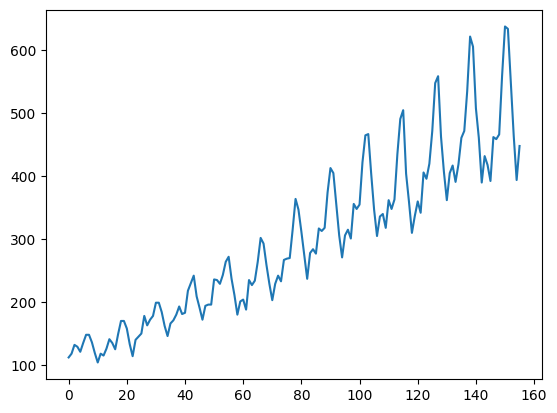

In [5]:
plt.plot(np.append(Y_train_df['y'].values, y_hat_test_w_val))

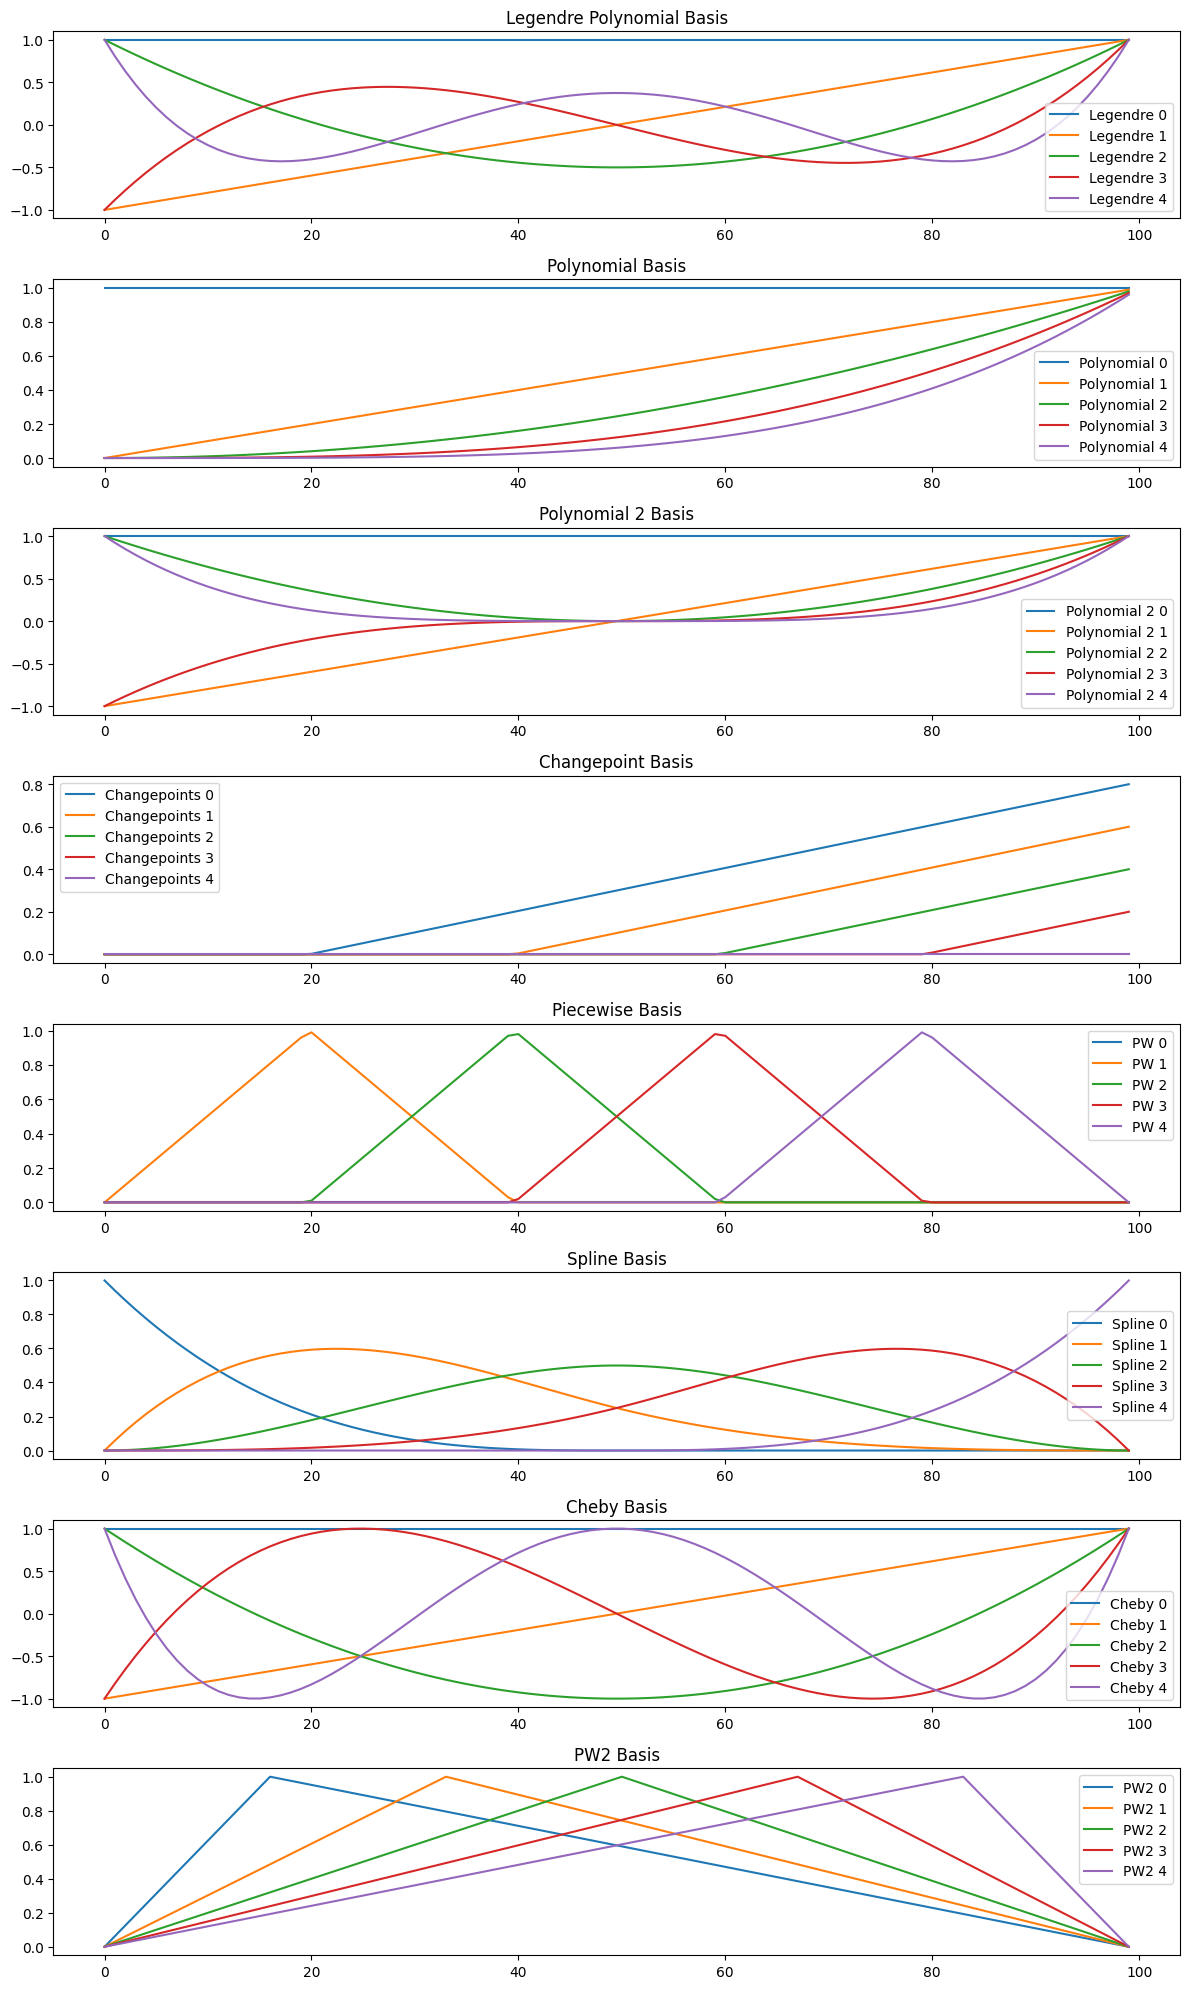

In [10]:
if __name__ == '__main__':
  # Example usage:
  n_points = 100  # Number of points in time series
  n_functions = 5  # Number of basis functions

  # Generate Legendre polynomial basis functions
  legendre_basis = generate_legendre_basis(n_points, n_functions)

  # Generate standard polynomial basis functions
  poly_basis = generate_polynomial_basis(n_points, n_functions)

  # Generate standard polynomial basis functions
  poly_2_basis = generate_polynomial_2_basis(n_points, n_functions)

  # Generate changepoint basis functions
  changepoint_basis = generate_changepoint_basis(n_points, n_functions)

  # Generate haar basis functions
  pw_basis = generate_piecewise_linear_basis(n_points, n_functions)

  # Generate haar basis functions
  spline_basis = generate_spline_basis(n_points, n_functions)

  # Generate haar basis functions
  cheby_basis = generate_chebyshev_basis(n_points, n_functions)

  # Generate haar basis functions
  pw2_basis = generate_piecewise_2_basis(n_points, n_functions)


  # Plotting the basis functions for visualization
  plt.figure(figsize=(12, 20))

  n_plots = 8

  # Plot Legendre basis functions
  plt.subplot(n_plots, 1, 1)
  for i in range(n_functions):
      plt.plot(legendre_basis[:, i], label=f'Legendre {i}')
  plt.title('Legendre Polynomial Basis')
  plt.legend()

  # Plot Polynomial basis functions
  plt.subplot(n_plots, 1, 2)
  for i in range(n_functions):
      plt.plot(poly_basis[:, i], label=f'Polynomial {i}')
  plt.title('Polynomial Basis')
  plt.legend()

  # Plot Polynomial 2 basis functions
  plt.subplot(n_plots, 1, 3)
  for i in range(n_functions):
      plt.plot(poly_2_basis[:, i], label=f'Polynomial 2 {i}')
  plt.title('Polynomial 2 Basis')
  plt.legend()

  # Plot Changepoint basis functions
  plt.subplot(n_plots, 1, 4)
  for i in range(n_functions):
      plt.plot(changepoint_basis[:, i], label=f'Changepoints {i}')
  plt.title('Changepoint Basis')
  plt.legend()

  # Plot Changepoint basis functions
  plt.subplot(n_plots, 1, 5)
  for i in range(n_functions):
      plt.plot(pw_basis[:, i], label=f'PW {i}')
  plt.title('Piecewise Basis')
  plt.legend()

  # Plot Changepoint basis functions
  plt.subplot(n_plots, 1, 6)
  for i in range(n_functions):
      plt.plot(spline_basis[:, i], label=f'Spline {i}')
  plt.title('Spline Basis')
  plt.legend()

  # Plot Changepoint basis functions
  plt.subplot(n_plots, 1, 7)
  for i in range(n_functions):
      plt.plot(cheby_basis[:, i], label=f'Cheby {i}')
  plt.title('Cheby Basis')
  plt.legend()

  # Plot Changepoint basis functions
  plt.subplot(n_plots, 1, 8)
  for i in range(np.shape(pw2_basis)[1]):
      plt.plot(pw2_basis[:, i], label=f'PW2 {i}')
  plt.title('PW2 Basis')
  plt.legend()

  plt.tight_layout()
  plt.show()
